**Dependencies**

In [15]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.ndimage import maximum_filter
from scipy.spatial.distance import cdist
from imblearn.datasets import fetch_datasets
from matplotlib import pyplot as plt
import seaborn as sns

**Dataset**

In [16]:
ecoli = fetch_datasets()['ecoli']
X, y = ecoli.data, ecoli.target
print(X.shape, y.shape)

(336, 7) (336,)


**Conversion to 2D using PCA**

In [17]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

**Visualize data**

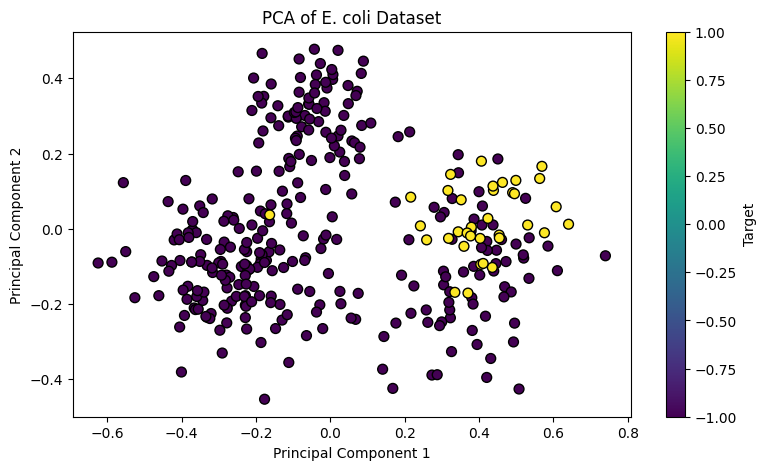

In [18]:
plt.figure(figsize=(9, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of E. coli Dataset')
plt.colorbar(label='Target')
plt.show()

**Detect majority and minority class**

In [19]:
def get_majority_minority_classes(y):
    unique, counts = np.unique(y, return_counts=True)
    majority_class = unique[np.argmax(counts)]
    minority_class = unique[np.argmin(counts)]
    return majority_class, minority_class

majority_class, minority_class = get_majority_minority_classes(y)

**Split majority and minority data**

In [20]:
def split_by_class(X, y, majority_class, minority_class):
    X_majority = X[y == majority_class]
    X_minority = X[y == minority_class]
    return X_majority, X_minority

X_majority_pca, X_minority_pca = split_by_class(X_pca, y, majority_class, minority_class)        

**KDE visualization**

<Axes: >

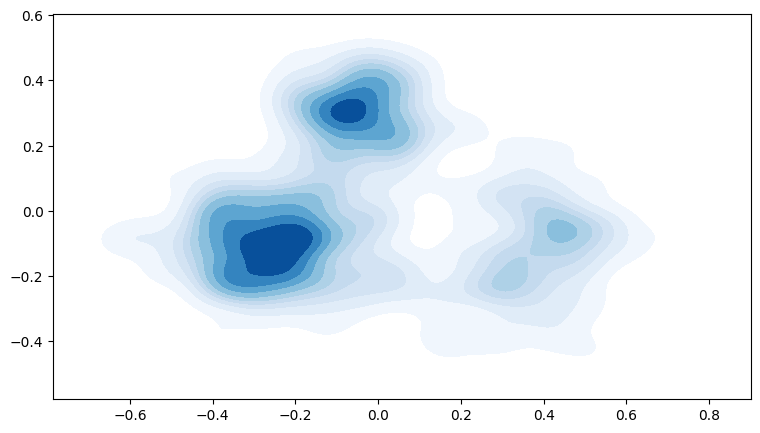

In [21]:
plt.figure(figsize=(9, 5))
sns.kdeplot(x=X_majority_pca[:, 0], y=X_majority_pca[:, 1], cmap="Blues", fill=True, bw_adjust=0.5)

**KDE density estimation**

KDE calculates where data points are more or less concentrated. KernelDensity model is created with a *bandwidth*. Small *bandwidth* creates sharp density peaks, larger smooths it out more. Higher grid size creates more detailed density map, but takes more computation time. We can visualize density it using heatmap, where darker regions are more concetrated and lighter regions less.

In [22]:
def kde_density(X, bandwidth=0.1, grid_size=100):
    """
    Compute the KDE density using sklearn's KernelDensity.
    
    Args:
        X (np.ndarray): 2D data array of shape (n_samples, n_features).
        bandwidth (float): Bandwidth for the Gaussian kernel. Smaller values create more detailed (but noisier) estimate, while a larger smooths the density.
        grid_size (int): Size of the grid for density evaluation.
    
    Returns:
        density (np.ndarray): 2D array of density values.
        xx (np.ndarray): X-coordinates of the grid.
        yy (np.ndarray): Y-coordinates of the grid.
    """
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth)
    kde.fit(X)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size), np.linspace(y_min, y_max, grid_size))
    grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
    
    log_density = kde.score_samples(grid_points)
    density = np.exp(log_density).reshape(xx.shape)
    
    return density, xx, yy

density, xx, yy = kde_density(X_majority_pca)

**Detecting high density regions and centers**

This function identifies regions in a 2D density map with the **highest density values** and returns the coordinates of the centers of those regions. It uses the *maximum_filter* function to detect local maxima, where the *filter_size* parameter defines the size of the neighborhood to check for maxima. The centers are sorted by density values, and the top N centers are returned. We use local maxima (instead of global) because we want to find multiple high density regions and not a single largest one.

In [23]:
def find_high_density_centers(density, xx, yy, num_centers=5, filter_size=5):
    """
    Find centers of high-density regions in a 2D density map.
    
    Args:
        density (np.ndarray): 2D array of density values.
        xx (np.ndarray): X-coordinates of the density grid.
        yy (np.ndarray): Y-coordinates of the density grid.
        num_centers (int): Number of high-density centers to detect.
        filter_size (int): Size of the filter for local maxima detection.
    
    Returns:
        List of (x, y) tuples representing high-density centers.
    """
    local_max = maximum_filter(density, size=filter_size) == density
    maxima_coords = np.argwhere(local_max)
    maxima_values = density[local_max]
    
    sorted_indices = np.argsort(maxima_values)[::-1]
    maxima_coords_sorted = maxima_coords[sorted_indices]
    
    centers = []
    for i in range(min(num_centers, len(maxima_coords_sorted))):
        row, col = maxima_coords_sorted[i]
        centers.append((xx[0, col], yy[row, 0]))

    return centers

centers = find_high_density_centers(density, xx, yy)
print("Number of centers found: ", len(centers))

Number of centers found:  3


**Find top N% closest prototypes to each center**

This function identifies the top **N% closest points** (prototypes) in the dataset to each high-density center, based on Euclidean distance. For each center, it calculates the distances of all points in the dataset to the center, sorts them, and selects the closest ones based on the specified percentage (*top_percentage*). The result is a dictionary where each center is mapped to the indices of its closest points. This is useful for identifying representative samples near key regions of interest in the data.

In [24]:
def find_closest_prototypes(X, centers, top_percentage=10):
    """
    Find the top N% closest prototypes to each high-density center.

    Args:
        X (np.ndarray): Original dataset of prototypes.
        centers (list): List of (x, y) tuples representing high-density centers.
        top_percentage (float): Percentage of closest prototypes to find (e.g., 10 for top 10%).

    Returns:
        dict: A dictionary where keys are center indices, and values are arrays of indices of the closest prototypes.
    """
    num_points = len(X)
    num_to_select = max(1, int((top_percentage / 100) * num_points))

    distances = cdist(X, centers, metric="euclidean")
    closest_prototypes = {}

    for center_idx in range(len(centers)):
        center_distances = distances[:, center_idx]
        sorted_indices = np.argsort(center_distances)
        closest_prototypes[center_idx] = sorted_indices[:num_to_select]

    return closest_prototypes

closest_prototypes = find_closest_prototypes(X_majority_pca, centers)

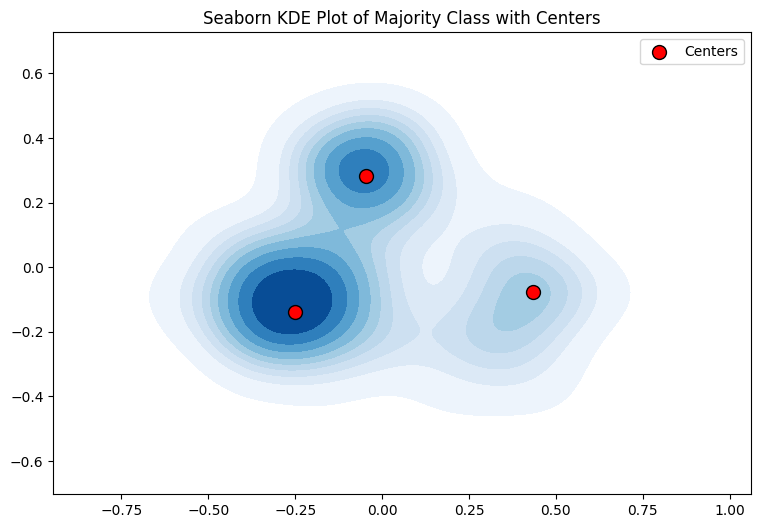

In [25]:
def show_region_centers_kde_plot(X_pca, centers):
    plt.figure(figsize=(9, 6))

    sns.kdeplot(
        x=X_pca[y == majority_class][:, 0],
        y=X_pca[y == majority_class][:, 1],
        cmap='Blues', fill=True, thresh=0.05, label='Majority Class'
    )

    centers_x, centers_y = zip(*centers)
    plt.scatter(centers_x, centers_y, color='red', s=100, edgecolor='k', label='Centers')

    plt.title("Seaborn KDE Plot of Majority Class with Centers")
    plt.legend()
    plt.show()

show_region_centers_kde_plot(X_pca, centers)

**Extract prototypes from dataset**

In [26]:
def extract_prototypes(X_majority_pca, closest_prototypes):
    """Extract prototypes based on closest points to high-density centers."""
    prototypes = np.vstack([X_majority_pca[closest_prototypes[i]] for i in range(len(closest_prototypes))])
    return prototypes

prototypes = extract_prototypes(X_majority_pca, closest_prototypes)
print("Number of prototypes extracted: ", len(prototypes))

Number of prototypes extracted:  90


**Merge prototypes and minority instances**

In [27]:
def merge_prototypes_and_minority(X_minority_pca, prototypes):
    """Merge prototypes with the minority class."""
    merged_data_pca = np.vstack((X_minority_pca, prototypes))
    merged_labels = np.hstack((np.zeros(len(X_minority_pca)), np.ones(len(prototypes))))

    merged_data = pca.inverse_transform(merged_data_pca) if pca else merged_data_pca

    return merged_data, merged_labels

merged_data, merged_labels = merge_prototypes_and_minority(X_minority_pca, prototypes)
print("Merged data shape: ", merged_data.shape)

Merged data shape:  (125, 7)


**Visualize prototypes and minority instances**

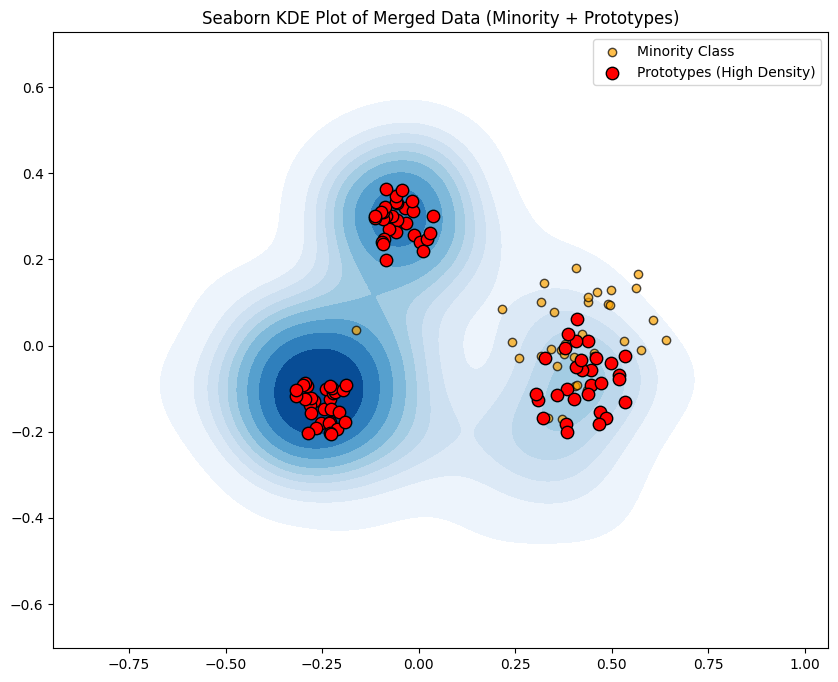

In [28]:
def show_merged_data_with_prototypes(X_pca, y, majority_class, X_minority_pca, prototypes, majority_density):
    """
    Visualize the merged dataset using a Seaborn KDE plot.
    
    Args:
        X_minority_pca (np.ndarray): PCA-transformed data for the minority class.
        prototypes (np.ndarray): PCA-transformed prototypes.
        majority_density (np.ndarray): Density values for the majority class.
    """
    plt.figure(figsize=(10, 8))

    sns.kdeplot(
        x=X_pca[y == majority_class][:, 0],
        y=X_pca[y == majority_class][:, 1],
        cmap='Blues', fill=True, thresh=0.05, label='Majority Class'
    )

    plt.scatter(
        X_minority_pca[:, 0], X_minority_pca[:, 1],
        label='Minority Class', color='orange', alpha=0.7, edgecolor='k'
    )

    plt.scatter(
        prototypes[:, 0], prototypes[:, 1],
        label='Prototypes (High Density)', color='red', s=80, edgecolor='k'
    )

    plt.title("Seaborn KDE Plot of Merged Data (Minority + Prototypes)")
    plt.legend()
    plt.show()

show_merged_data_with_prototypes(X_pca, y, majority_class, X_minority_pca, prototypes, density)